We would like to infer the distances in twelve velocity slices of a spectral cube, covering the molecular cloud complex Cepheus. We would like to do this using the stellar photometry of stars towards Cepheus and the intensity of the carbon monoxide emission in each velocity slice of the spectral cube towards this same region. This is what we ultimately wish to infer: 

$$p(\alpha \mid I, m)$$ 

where $$\alpha=(d_1, d_2, ... , d_k)$$ 
and...  
$d$=distance to slice (12 d's for 12 velocity slices)  
$I$= gas emission intensities that will act as dust templates, and which will be converted to extinction with a gas-to-dust coefficient  
$m$= set of stellar photometry for all stars  

By doing so, we'll be able to compare our dust-based distances to the velocity slices with the distances to the same slices given by a Galactic rotation curve. 

Our aim of inferring the distance and gas-to-dust coefficient for each velocity slice starts with inferring the distance and reddening for each individual star in our region of interest.  The probability density of finding an individual star j at distance $\mu_j$ and with stellar fluxes $m_j$ is given by $p(\mu_j, E_j | m_j)$ This probability density has already been precomputed in Green et al. 2015, using a kernel density estimate of MCMC samples. We parameterize the line-of-sight reddening profile towards an individual star, $E_j$, with the following model: 

$$E_{j} (\mu_j, \alpha)  = \sum_{k \rightarrow d_k < \mu_j} I_{j,k} \times c$$ 

with $I_{j,k}$= intensity of gas emission in the pixel corresponding to the jth star in the kth velocity slice and $c$= gas to dust conversion coefficient given by the literature. We're summing over the emission in all the velocity slices such that the distance to the velocity slice is less than the distance to our star $\mu$. The form of the reddening profile will be piecewise linear. 

So, going back to Bayes Rule, we know that: 

$$p(\alpha \mid I, m) \propto p(I, m \mid \alpha) \times p(\alpha) \propto p(I, m \mid \alpha)$$ 

with the first term, $p(I, m \mid \alpha)$, being our likelihood function and the second terms being our prior function; we're assuming a flat prior for d. 

According to Green et al. 2014, the likelihood for an individual star is given by 

$$p(m_j \mid \alpha) \propto \int p(\mu_j, E_j(\mu_j; \alpha) \mid m_j) \; d\mu_j$$

With the likelihood of the entire set of stars given by the product of the individual likelihoods. 

Where does this come from? We know that the likelihood of the set of stellar photometry also depends on the distance modulus to the star $\mu$ and the stellar type $\theta$, so we'll add those in and marginalize over them later. For the next few steps, we're going to drop the j subscript, since we know we're talking about a single star: 

$$p(m \mid \alpha) \propto \int d\mu \; d\theta \; p(m, \mu, \theta \mid \alpha)$$ 
$$\propto \int d\mu \; d\theta \; p(m \mid  \mu, \theta, \alpha) p(\mu, \theta \mid \alpha)$$
$$\propto \int d\mu \; d\theta \; p(m \mid \mu, \theta, E(\mu;\alpha))p(\mu, \theta)$$

In the last step, we are assuming that the reddening profile extinction is defined by the $\alpha$ parameters; we are also assuming that the joint prior on distance $\mu$ and stellar type $\theta$ are independent of E. 

The integrand in the last equation is basically (up to a normalizing constant) a prior times a likelihood, so our likelihood is essentially the integral of the posterior density $p(\mu,E, \theta \mid m)$ 

However, we don't really care about stellar type, so we are going to marginalize over it; adding back in the j subscript, for the jth star, this leaves us with... 

$$p(m_j \mid \alpha) \propto \int p(\mu_j, E_j(\mu_j; \alpha) \mid m_j)\; d\mu_j$$

Now understanding where this expression comes, we can put everything together and determine the posterior probability density of the $\alpha$ parameters by taking the product over line integrals through the individual stellar probability density functions (already precomputed), along the reddening profile for the star, $E_j (\mu_j; \alpha)$: 

$$p(\alpha \mid I, m) \propto p(c) \times p(d) \prod_j \int p(\mu_j, E_j(\mu_j; \alpha) \mid m_j, I) \; d\mu_j$$

This is what what we'll ultimately have to sample from, using Parallel Tempering MCMC analysis. 

Now we need to do some code testing using simulated data, to ensure that our code is functioning properly. To do this, we need to produce simulated data such that we know what the "true" answer is for the parameter estimation problem we are trying to solve. To do this, we are going to create a reddening "profile" or a plot of the cumulative reddening as a function of distance. In this profile, there are going to be two clouds along the line of sight, corresponding to two jumps in reddening in our reddening profile. We are going to have our reddening profile look like this: 

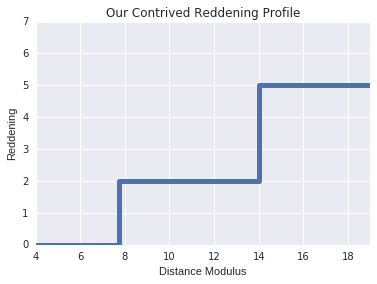

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

distance=np.array([4,7.75,7.75,14,14,19])
fake_reddening=np.array([0,0,2,2,5,5])

plt.plot(distance, fake_reddening,lw=5)
plt.xlabel(r'Distance Modulus')
plt.ylabel('Reddening')
plt.xlim(4,19)
plt.ylim(0,7)
plt.title("Our Contrived Reddening Profile")
plt.savefig("contrived_profile.pdf")

From the reddening profile, we can tell that this is a two cloud model towards a specific line of sight. We see that there are no clouds (and thus no reddening) between a distance modulus of 4 and 7.75. Then, we see that there's a cloud of dust at 7.75 which adds 2 magnitudes of reddening to our profile. Then we see that there's a second dust cloud at a distance modulus of 14 that adds 3 magnitudes of reddening to our profile, bringing our cumulative reddening at distance modulus 14 and beyond up to 5 magnitudes. 

So, now we need to produce some stellar posterior data (700x120 arrays of reddening vs. distance) to match our contrived profile. To do this, we are going to randomly sprinkle 50 stars along the line of sight. Since we are working with stellar posterior arrays, we are going to mentally convert everything from actual distance and reddening to distance and reddening bins in the stellar posterior arrays. Axis 0 of the array (the vertical axis) has a reddening range from 0-7 magnitudes, $\Delta_{reddening}$=0.01 magnitudes (total of 700 bins). Axis 0 of the array (the horizontal axis) has a distance modulus range from 4-19, so $\Delta_{distmod}$=0.125 (total of 120 bins). Our clouds in our contrived reddening profile correspond to distance modulus bins of 30 and 80, and reddening bins of 200 and 500. So now we randomly sprinkle 50 stars along the distance axis of the array, and then look up the reddening those stars should have based on our reddening profile. To produce the posterior for a single star we draw 5000 random samples from bivariate normal distribution with a mean centered at the randomly generated distance and the corresponding reddening value given by the reddening profile. We let the standard deviation of the bivariate normal distribution be 0.1 in both distance and reddenings, resulting in "puffy" clouds. We then use the samples to populate a 2D histogram, which is now our 700x120 stellar posterior array for a single star. We repeat this 49 more times for 49 more stars. This is how we code that: 

In [13]:
import pandas as pd

nstars=75

#randomly sprinkle 50 stars at 50 distances along the posterior horizontal axis (total bins=120)
randdist=np.random.randint(0,119,nstars)

#create our array to hold the corresponding reddening values taken from our contrived reddening profile 
red=np.empty(nstars)

for i in range(0,nstars):
    if randdist[i] < 30: #no clouds at a distance modulus bin <30, so reddening is zero
        red[i]=0
    
    if randdist[i] >= 30 and randdist[i] < 80: #one cloud between distance modulus bin of 30-80 (with reddening=2 mags)
        red[i]=200
    
    if randdist[i] >= 80: #two cloud between distance modulus bin of 80-120 (with cumulative reddening=5 mags)
        red[i]=500

#create array to hold our stellar posterior information 
post_array=np.empty((nstars,700,120))

#repeat 50 times for 50 stars
for i in range(0,nstars):
    mean=np.array([randdist[i],red[i]]) #mean of bivariate normal distribution set to random distance and corresponding reddening value
    cov=np.array([[1,0],[0,100]]) #standard deviations of ~0.1 in both reddening and distance modulus, converted to the number of bins that corresponds to on each axis
    data = np.random.multivariate_normal(mean, cov, 5000) #draw samples from that distribution
    df = pd.DataFrame(data, columns=["mu", "E"])
    H, yedges, xedges = np.histogram2d(df['E'],df['mu'],bins=[700,120], range=[[0, 700], [0, 120]]) #use those samples to create 2dhistogram, our stellar posterior!
    post_array[i,:,:]=H #store the posterior array for that star


We've plotted below what the posterior would look like if you stacked all the individual stellar posteriors on top of eachother (i.e. you summed along the depth axis). See that it looks similar to our contrived reddening profile, which is what we want! Note that the x and y axes correspond to the bin indices. When we integrate over distance modulus in our likelihood function, we only care about the reddening "ledges". We'll perform this integral from distance modulus=4 to distance modulus=19, over the entire length of the stellar posterior array for each individual star. 

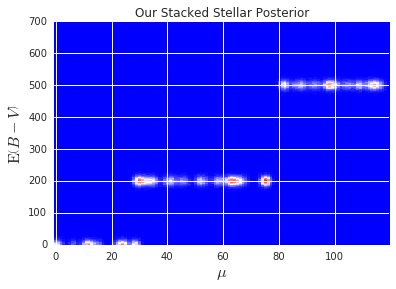

In [14]:
sumarray=np.sum(post_array, axis=0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mu$', fontsize=16)
ax.set_ylabel(r'$\mathrm{E} \left( B - V \right)$', fontsize=16)
ax.imshow(sumarray, origin='lower',aspect='auto', cmap='bwr', interpolation='nearest')
ax.set_title("Our Stacked Stellar Posterior")
plt.savefig("simulated_stacked.pdf")

Now we are going to make some fake CO (carbon monoxide) data to go with our fake stellar posteriors. We have twelve CO intensity values for each star (for twelve CO velocity slices). The set of intensity values will be the same for each star, since they are all presumed to be along the same line of sight. Our fake reddening profile corresponds to two clouds (two CO emission features) at two different velocity slices. The first cloud has a reddening of 2 magnitudes, producing a cumulative reddening of 2 magnitudes. The second cloud has a reddening of 3 magnitudes, producing a cumulative reddening of 5 magnitudes (3 from itself and 2 from the other cloud). Setting our gas to dust coefficient to one for testing purposes, this means that we need to set one slice to CO intensity ("CO_I") value of 2 and the second slice to a CO intensity value of 3. All the other velocity slice intensities will be set to zero, because we are assuming there are only two clouds in all the slices. 

It doesn't really matter which two slices we put our clouds in (it only matters what distances our parameter estimation problem gives us for the two slices). Thus, let's put the first cloud (CO_I=2) in velocity slice 7 and our second cloud (CO_I=3) in velocity slice 11.  So for a single star, our CO intensities for velocity slices 1-12 look like this: [0,0,0,0,0,0,2,0,0,0,0,3,0]. Now we have a stellar posterior array and a CO intensity array for every star. We write all this information out into a "simulated_data.h5" file:

In [15]:
import h5py

nstars=75
nslices=12

fwrite = h5py.File("simulated_data.h5", "w")
pdfs = fwrite.create_dataset("/stellar_pdfs", (nstars,700,120), dtype='f')
pdfs[:,:,:]=post_array #write our stellar posterior arrays calculated above to an hdf5 dataset

intensity=np.array([0,0,0,0,0,0,2,0,0,0,3,0]) #our identical CO array for every star

co_array=np.empty((nstars,12)) 

for i in range(0,nstars):
    co_array[i,:]=intensity

co_data = fwrite.create_dataset("/co_data", (nstars,nslices), dtype='f')
co_data[:,:]=co_array #write our co arrays to an hdf5 dataset

fwrite.close()

Based on our stellar posterior and CO data, we know what the values of d7 (the distance to velocity slice 7) and d11 (the distance to velocity slice 11) SHOULD be. D7 needs to be before D11, at a distance modulus of 7.75 and D11 needs to be at a distance modulus of 14. Having those velocity slices correspond to those distances will produce the highest value of the line integral along our reddening profile (see initial reddening profile figure), which is essentially our likelihood function. The distances to the other ten slices cannot be constrained because their intensities are set to zero and thus contribute nothing to the reddening profile. 

Because our distributions are likely to be multi-modal, we are going to use Parallel-Tempering MCMC. To ensure that we aren't getting the "right" answer by chance, we are going to randomly set our walkers off within a reasonable distance range surrounding each cloud. For the d7 parameter, we are going to set our walker off somewhere between a distance modulus of 8 and 14, for our d11 parameter we are going to set our walker off somewhere between a distance modulus of 14 and 19. This way, we are sure not to initialize our walkers at an area of negative infinity probability, while still making it somewhat difficult for them the find their way back. Our final answers don't have to be exact (because we'd need a lot more simulated stars along the line of sight to make it perfect) but it does have to be close. Moreover, our distance estimates should get better if we increase the number of stars and should get worse if we increase the standard deviation of the bivariate Gaussian's we used to create the probability surfaces in our stellar posterior array. Let's see what happens...

CPU times: user 9min 36s, sys: 869 ms, total: 9min 37s
Wall time: 9min 36s
Done
Our mean acceptance fraction for the hottest chain is 0.19
d7 = 7.80 + 0.20 - 0.13
d11 = 14.03 + 0.28 - 0.29


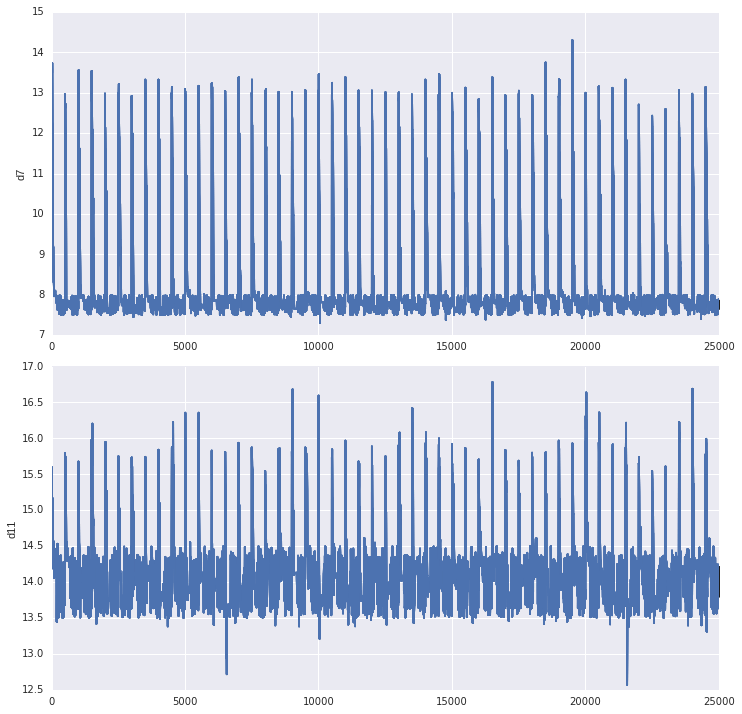

In [27]:
import emcee
from dustcurve import model_test
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dustcurve import io
import warnings
%matplotlib inline

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

# the model has 12 parameters; we'll use 50 walkers, 500 steps each, at 5 different temps
ndim=12
nwalkers = 50
nsteps = 500
ntemps=6

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args('simulated_data.h5',[4,19],1.0)

#set off the d7 and d11 parameters at random within a reasonable distance range surrounding the cloud
result=[np.random.randint(4,19) for i in range(ndim)]
result[6]=np.random.uniform(8,14)
result[10]=np.random.uniform(14,19)

#set up the starting position array and add variance (up to 1 in distance modulus) to each walker 
starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model_test.log_likelihood, model_test.log_prior, loglargs=(ldata), logpargs=[pdata])

# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

#Extract the highest temperature chain from the sampler object, which is least likely to get stuck at local maxima
samples_hot = sampler.chain[0,:,:,:]
traces_hot = samples_hot.reshape(-1, ndim).T

#check out acceptance fraction:
print("Our mean acceptance fraction for the hottest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#set up the figures to plot the hot chain
fig, (ax_d7, ax_d11) = plt.subplots(2, figsize=(10,10))
plt.tight_layout()
ax_d7.set(ylabel='d7')
ax_d11.set(ylabel='d11')

#plot the chains for the first ten walkers
for i in range(0,10):
    sns.tsplot(traces_hot[6], ax=ax_d7)
    sns.tsplot(traces_hot[10], ax=ax_d11)
    
parameter_samples = pd.DataFrame({'d7': traces_hot[6], 'd11': traces_hot[10]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

#what values do we get?
print("d7 = {:.2f} + {:.2f} - {:.2f}".format(q['d7'][0.50], 
                                            q['d7'][0.84]-q['d7'][0.50],
                                            q['d7'][0.50]-q['d7'][0.16]))
print("d11 = {:.2f} + {:.2f} - {:.2f}".format(q['d11'][0.50], 
                                            q['d11'][0.84]-q['d11'][0.50],
                                            q['d11'][0.50]-q['d11'][0.16]))



Success! We see that we returned a value of 7.80 for d7 and 14.03 for d11, whereas the true values are given by 7.75 and 14.00. Thus, our PTSampler produced accurate results, well within the estimated uncertainties. We are all set to move on to real data! 